## Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import requests, zipfile, io
from joblib import Parallel, delayed
import warnings

In [2]:
movies = pd.read_csv('ml-latest-small/movies.csv')
ratings = pd.read_csv('ml-latest-small/ratings.csv')

## Exploratory data analysis

In [3]:
df = movies.merge(ratings , on='movieId')
df.columns

Index(['movieId', 'title', 'genres', 'userId', 'rating', 'timestamp'], dtype='object')

In [4]:
movies_count = df['movieId'].nunique()
users_count = df['userId'].nunique()
print("Number of movies:", movies_count)
print("Number of users:", users_count)
num_rows = df.shape[0]
print("Number of ratings:", num_rows)
print("average ratings per user:",num_rows /users_count)

Number of movies: 9724
Number of users: 610
Number of ratings: 100836
average ratings per user: 165.30491803278687


all users have at least 20 ratings


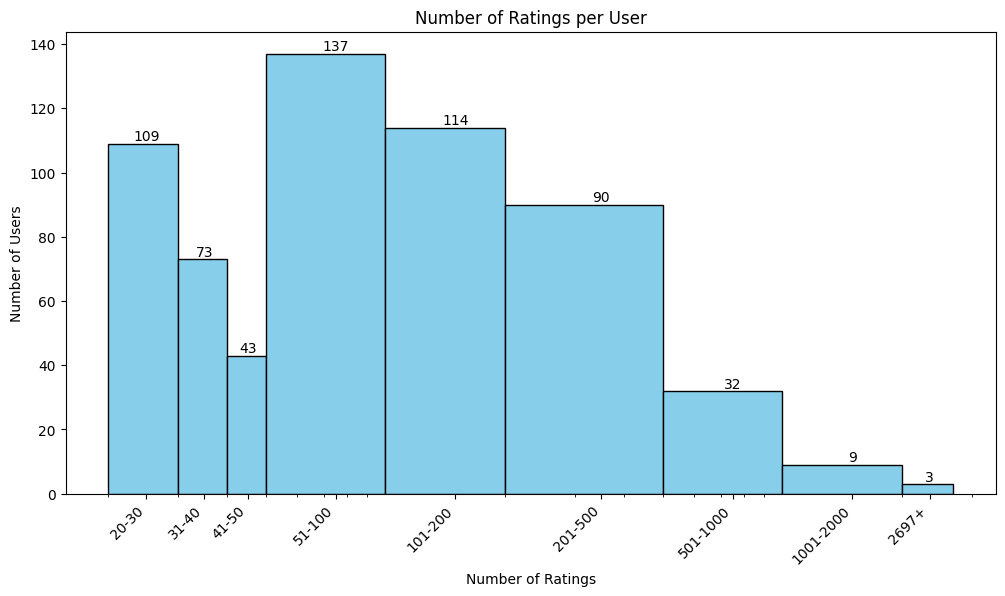

In [5]:
ratings_per_user = df.groupby('userId')['movieId'].count()
min_ratings = ratings_per_user.min()
print("all users have at least", min_ratings ,"ratings")
# Define bins for ranges
bins = [20, 30, 40, 50, 100, 200, 500, 1000, 2000, ratings_per_user.max()]  # Start from 20

# Plot the histogram of ratings per user
plt.figure(figsize=(12, 6))
hist, bins, _ = plt.hist(ratings_per_user, bins=bins, color='skyblue', edgecolor='black')
plt.xscale('log')  # Log scale for better visualization

# Labeling the x-axis ticks with actual values
tick_labels = ['20-30', '31-40', '41-50', '51-100', '101-200', '201-500', '501-1000', '1001-2000', f'{ratings_per_user.max() - 1}+']
tick_positions = [np.mean([bins[i], bins[i+1]]) for i in range(len(bins)-1)]
plt.xticks(tick_positions, tick_labels, rotation=45, ha='right')

plt.title('Number of Ratings per User')
plt.xlabel('Number of Ratings')
plt.ylabel('Number of Users')

# Add text annotations on top of each bar
for i, count in enumerate(hist):
    plt.text(bins[i] + (bins[i + 1] - bins[i]) / 2, count, str(int(count)), ha='center', va='bottom', fontsize=10, color='black')

plt.show()


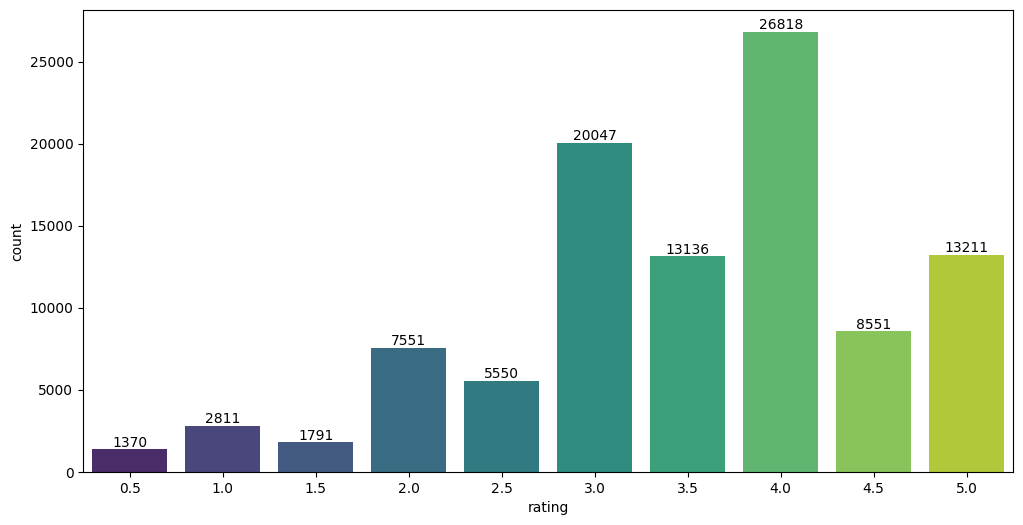

In [6]:
with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    
    # Plot a countplot to visualize the distribution of ratings
    plt.figure(figsize=(12, 6))
    sns.countplot(x='rating', data=df, palette='viridis')
    
    # Annotate each bar with its count value
    for p in plt.gca().patches:
        plt.gca().annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                           ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                           textcoords='offset points')


    plt.show()

In [7]:
ratings_per_movie = df.groupby('movieId')['userId'].count()
ratings_per_movie

movieId
1         215
2         110
3          52
4           7
5          49
         ... 
193581      1
193583      1
193585      1
193587      1
193609      1
Name: userId, Length: 9724, dtype: int64

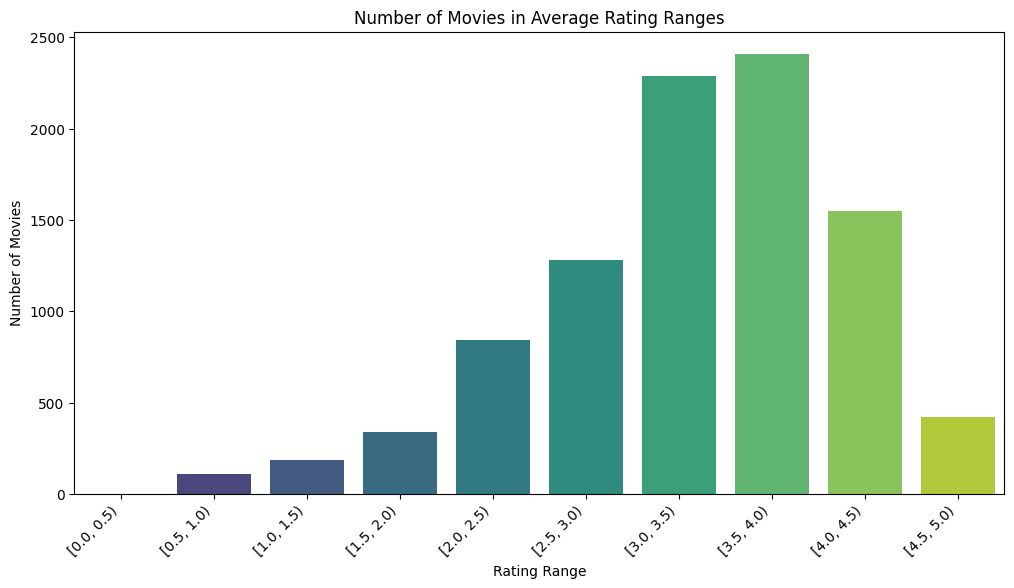

In [8]:

# Calculate average rating per movie
average_rating_per_movie = df.groupby('movieId')['rating'].mean()

# Create bins for rating ranges
bins = [i * 0.5 for i in range(11)]
with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    # Bin the average ratings into ranges and count the number of movies in each range
    rating_ranges = pd.cut(average_rating_per_movie, bins, right=False)
    count_per_range = rating_ranges.value_counts().sort_index()
    
    # Plot the count of movies in each rating range
    plt.figure(figsize=(12, 6))
    sns.barplot(x=count_per_range.index.astype(str), y=count_per_range.values, palette='viridis')
    
    # Add labels and title
    plt.title('Number of Movies in Average Rating Ranges')
    plt.xlabel('Rating Range')
    plt.ylabel('Number of Movies')
    
    # Rotate x-axis labels for better visibility
    plt.xticks(rotation=45, ha='right')

    # Show the plot
    # plt.show()


In [9]:
df.describe()

,movieId,userId,rating,timestamp
count,100836.000000,100836.000000,100836.000000,1.008360e+05
mean,19435.295718,326.127564,3.501557,1.205946e+09
std,35530.987199,182.618491,1.042529,2.162610e+08
min,1.000000,1.000000,0.500000,8.281246e+08
25%,1199.000000,177.000000,3.000000,1.019124e+09
50%,2991.000000,325.000000,3.500000,1.186087e+09
75%,8122.000000,477.000000,4.000000,1.435994e+09
max,193609.000000,610.000000,5.000000,1.537799e+09


## data preprocessing

In [10]:
df.drop(['genres' , 'timestamp'] , axis=1 , inplace=True)

In [11]:
# Filter the DataFrame to include only liked movies (rating 3 stars or more)
liked_movies_df = df[df['rating'] >= 3]

# Group by 'userId' and aggregate the liked movies into a list
user_liked_movies = liked_movies_df.groupby('userId')['title'].agg(list).reset_index()

# Rename the column to 'liked_movies'
user_liked_movies.rename(columns={'title': 'liked_movies'}, inplace=True)

user_liked_movies

,userId,liked_movies
0,1,"[Toy Story (1995), Grumpier Old Men (1995), He..."
1,2,"[Shawshank Redemption, The (1994), Tommy Boy (..."
2,3,"[Escape from L.A. (1996), Highlander (1986), S..."
3,4,"[Get Shorty (1995), To Die For (1995), Mighty ..."
4,5,"[Toy Story (1995), Get Shorty (1995), Babe (19..."
...,...,...
604,606,"[Cutthroat Island (1995), Sense and Sensibilit..."
605,607,"[Toy Story (1995), American President, The (19..."
606,608,"[GoldenEye (1995), Casino (1995), Get Shorty (..."
607,609,"[Toy Story (1995), GoldenEye (1995), Bravehear..."


## Training

In [19]:
# importing the library
try:
    import apyori
except:
    !pip install apyori

from apyori import apriori # for association rule learning models

In [82]:
transactions = user_liked_movies['liked_movies'].tolist()
len(transactions)  
test_set = transactions[210:250]

In [22]:
rules = apriori(transactions = transactions[0:200], min_support=0.00030, min_confidance=0.01, min_lift=3, min_length=2, max_length=2 , verbose = 1)
#let's transform them into a list
results = list(rules)

def inspect(results):
    '''
    function to put the result in well organised pandas dataframe
    '''
    lhs         = [tuple(result[2][0][0])[0] for result in results]
    rhs         = [tuple(result[2][0][1])[0] for result in results]
    supports    = [result[1] for result in results]
    confidences = [result[2][0][2] for result in results]
    lifts       = [result[2][0][3] for result in results]
    return list(zip(lhs, rhs, supports, confidences, lifts))

resultsinDataFrame = pd.DataFrame(inspect(results), columns = ['Item #1', 'Item #2', 'Support', 'Confidence', 'Lift'])
len(resultsinDataFrame)


1791860

## Testing

In [81]:
def recommendations(film) :
    
    result = resultsinDataFrame[(resultsinDataFrame['Item #1'] == film) | (resultsinDataFrame['Item #2'] == film) ]\
    .nlargest(n=20, columns='Support')
    
    
    ##################################################
    # moving the results to a list
    modified_results = result.copy()
    mask = modified_results['Item #2'] == film
    modified_results.loc[mask, 'Item #2'] = modified_results.loc[mask, 'Item #1']
    recommendations = modified_results[["Item #2" , "Support"]]
    return recommendations 


def multi_recommendation(films):
    combined_results = pd.DataFrame()

    for film in films:
        # Filter the results DataFrame for the current film
        filtered_results = recommendations(film)

        # Append the filtered results to the combined_results DataFrame
        combined_results = pd.concat([combined_results, filtered_results])

    # Reset the index of the combined DataFrame
    combined_results = combined_results.reset_index(drop=True)

    # Filter out rows where 'Item #2' is in the list of input movies
    combined_results = combined_results[~combined_results["Item #2"].isin(films)]

    combined_results = combined_results.drop_duplicates(subset='Item #2')
    # Get the top 20 recommendations based on 'Support'
    combined_results = combined_results.nlargest(n=20, columns='Support')

    return combined_results

## Evaluation 